# 영균의 EDA 및 예측 방향성
- 행정동별로 구역을 나누는 것도 방법이겠지만, 해당 정보는 위도와 경도 정보에 담겨 있다고 보고 예측을 진행해 보는 것도 좋을 것 같다. (구역을 나누는 방법과의 차이를 비교해봐도 좋을듯)
- deposit 값에 대해서는 이상치를 제거해야 한다고 생각하는 편. 다른 피처는 생각해 봐야겠다.
- contract_type에서 모른다 라고 응답한 값은 결측치로 보는 것이 좋겠다.
- 트리에서 xgb나 lgb는 많이들 할테니까 catboost 위주로 할 것이다.

In [43]:
import os
from typing import List, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
data_path: str = "../../data/"
train_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv"))
test_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv"))
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))
interest_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "interestRate.csv"))
park_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "parkInfo.csv"))
school_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "schoolinfo.csv"))
subway_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "subwayInfo.csv"))

In [45]:
subway_df

,latitude,longitude
0,37.759380,127.042292
1,37.541021,126.971300
2,37.529849,126.964561
3,37.514219,126.942454
4,37.513342,126.926382
...,...,...
695,37.378384,126.645168
696,37.386007,126.639484
697,37.393054,126.634729
698,37.399907,126.630347


In [46]:
train_data.drop("index", axis=1, inplace=True)
test_data.drop("index", axis=1, inplace=True)
train_data.head(10)

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0
5,84.9342,201904,26,2,13,2016,36.965423,127.048779,3,20000.0
6,39.2700,201905,7,2,3,1990,36.957089,127.047449,29,4000.0
7,84.9342,201905,9,2,3,2016,36.965423,127.048779,3,20000.0
8,84.9610,201905,25,2,3,2016,36.965423,127.048779,3,20500.0
9,84.9182,201905,25,2,13,2016,36.965423,127.048779,3,19000.0


In [47]:
from scipy.spatial import cKDTree

def find_closest_distance_kdtree(train_data, loc_df):
    train_coords = train_data[['latitude', 'longitude']].values
    park_coords = loc_df[['latitude', 'longitude']].values
    tree = cKDTree(park_coords)
    distances, _ = tree.query(train_coords)
    return distances

train_data["school_distance"] = find_closest_distance_kdtree(train_data, school_df)
train_data["park_distance"] = find_closest_distance_kdtree(train_data, park_df)
train_data["subway_distance"] = find_closest_distance_kdtree(train_data, subway_df)
test_data["school_distance"] = find_closest_distance_kdtree(test_data, school_df)
test_data["park_distance"] = find_closest_distance_kdtree(test_data, park_df)
test_data["subway_distance"] = find_closest_distance_kdtree(test_data, subway_df)

In [48]:
train_data = train_data.merge(interest_df, left_on='contract_year_month', right_on='year_month', how='left')
train_data.drop("year_month", axis=1, inplace=True)

In [49]:
test_data = test_data.merge(interest_df, left_on='contract_year_month', right_on='year_month', how='left')
test_data.drop("year_month", axis=1, inplace=True)

In [50]:
train_data["contract_year"] = train_data["contract_year_month"] // 100
train_data["contract_month"] = train_data["contract_year_month"] % 100
train_data.drop("contract_year_month", axis=1, inplace=True)
train_data

,area_m2,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,school_distance,park_distance,subway_distance,interest_rate,contract_year,contract_month
0,84.9981,25,2,9,2019,37.054314,127.045216,0,17000.0,0.001558,0.004779,0.007910,1.78,2019,6
1,84.9981,26,2,20,2019,37.054314,127.045216,1,23000.0,0.001558,0.004779,0.007910,1.26,2020,3
2,84.9981,28,2,8,2019,37.054314,127.045216,1,23000.0,0.001558,0.004779,0.007910,1.26,2020,3
3,59.3400,15,2,1,1986,36.964647,127.055847,33,5000.0,0.002046,0.001706,0.039234,1.68,2019,7
4,59.8100,12,2,6,1995,36.972390,127.084514,24,1800.0,0.015370,0.004277,0.018347,1.85,2019,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,114.8126,25,0,5,2010,37.528394,126.659398,13,39000.0,0.002454,0.004512,0.016569,4.00,2023,11
1801224,101.9088,28,0,6,2010,37.528394,126.659398,13,38000.0,0.002454,0.004512,0.016569,4.00,2023,11
1801225,114.7900,3,0,19,2010,37.528394,126.659398,13,37000.0,0.002454,0.004512,0.016569,3.84,2023,12
1801226,101.9088,4,1,15,2010,37.528394,126.659398,13,34400.0,0.002454,0.004512,0.016569,3.84,2023,12


In [51]:
test_data["contract_year"] = test_data["contract_year_month"] // 100
test_data["contract_month"] = test_data["contract_year_month"] % 100
test_data.drop("contract_year_month", axis=1, inplace=True)
test_data

,area_m2,contract_day,contract_type,floor,built_year,latitude,longitude,age,school_distance,park_distance,subway_distance,interest_rate,contract_year,contract_month
0,84.9610,12,1,14,2016,36.965423,127.048779,8,0.008568,0.003194,0.044314,3.54,2024,4
1,59.9000,13,0,4,1997,36.963105,127.040678,27,0.016303,0.001387,0.052359,3.54,2024,4
2,39.2700,29,0,5,1990,36.957089,127.047449,34,0.007719,0.002467,0.050533,3.54,2024,4
3,39.2700,3,0,1,1990,36.957089,127.047449,34,0.007719,0.002467,0.050533,3.56,2024,5
4,46.9800,2,0,4,1990,36.957089,127.047449,34,0.007719,0.002467,0.050533,NaN,2024,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150167,115.5101,27,0,17,2010,37.528394,126.659398,14,0.002454,0.004512,0.016569,3.62,2024,2
150168,142.8738,2,0,4,2010,37.528394,126.659398,14,0.002454,0.004512,0.016569,3.59,2024,3
150169,142.8738,16,1,13,2010,37.528394,126.659398,14,0.002454,0.004512,0.016569,3.59,2024,3
150170,114.9285,22,1,2,2010,37.528394,126.659398,14,0.002454,0.004512,0.016569,3.59,2024,3


# EDA

## Scatterplot

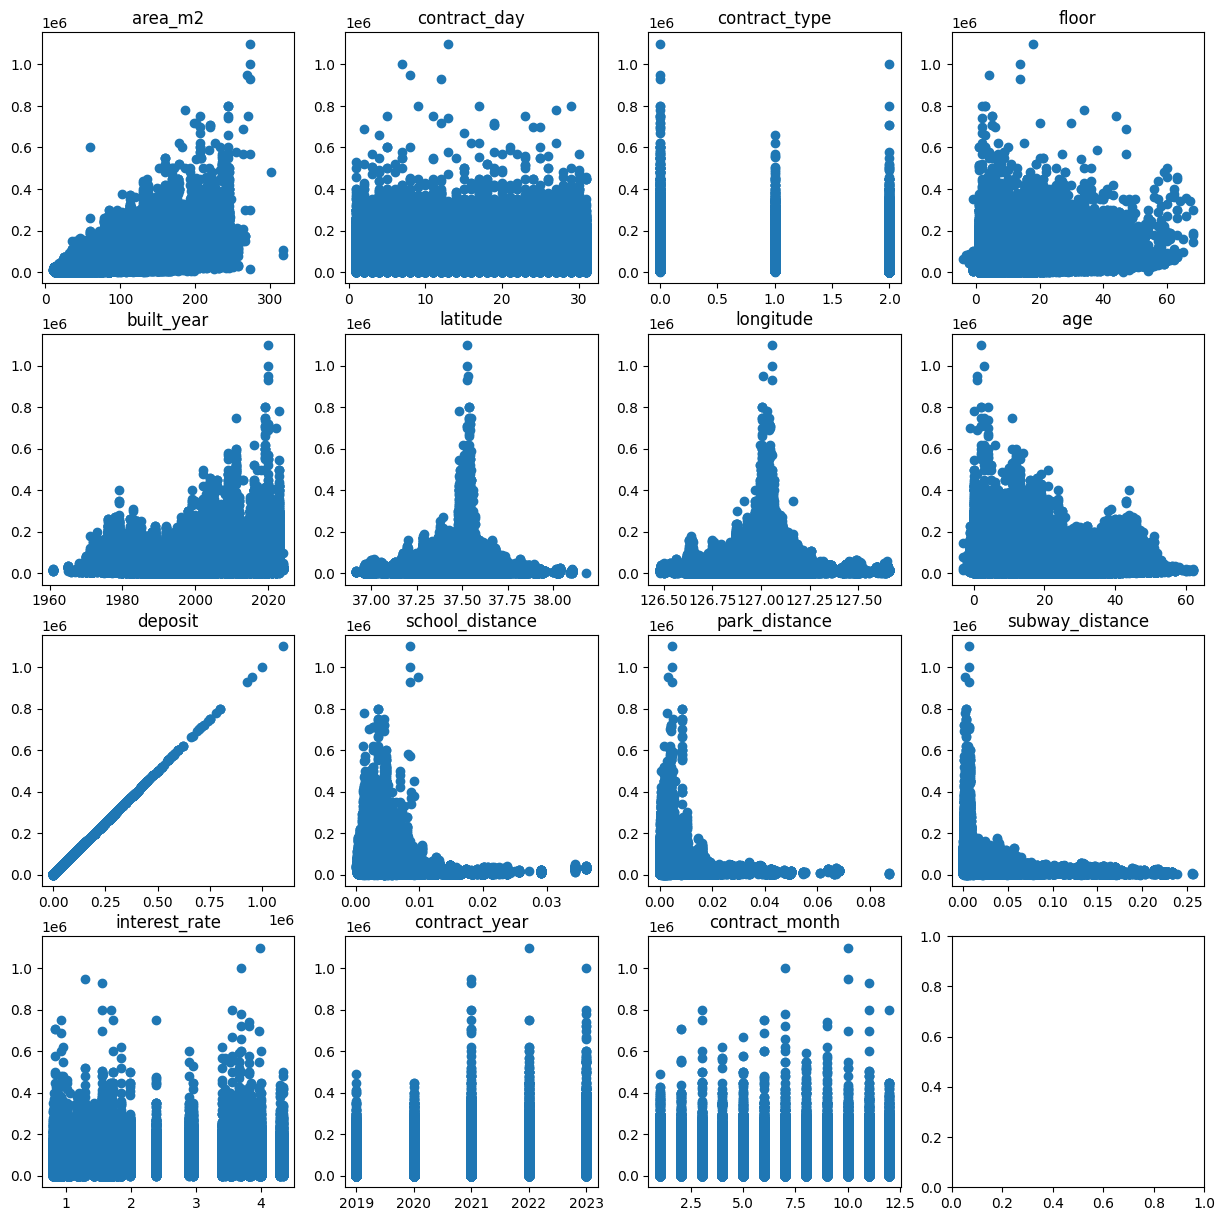

In [52]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for i, feature in enumerate(train_data.columns):
    axs[i//4, i%4].scatter(data=train_data, x=feature, y="deposit")
    axs[i//4, i%4].set_title(feature)

## Histplot

<Axes: xlabel='area_m2', ylabel='Count'>

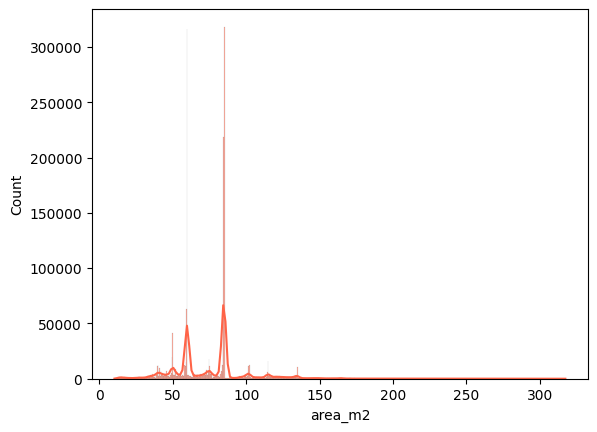

In [53]:
sns.histplot(data=train_data, x="area_m2", color="tomato", kde=True)

<Axes: xlabel='floor', ylabel='Count'>

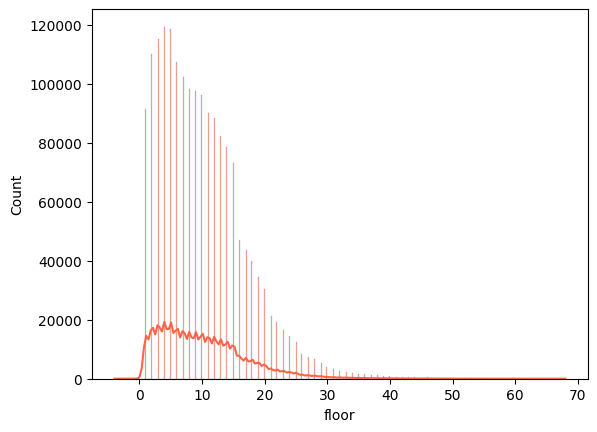

In [54]:
sns.histplot(data=train_data, x="floor", color="tomato", kde=True)

<Axes: xlabel='built_year', ylabel='Count'>

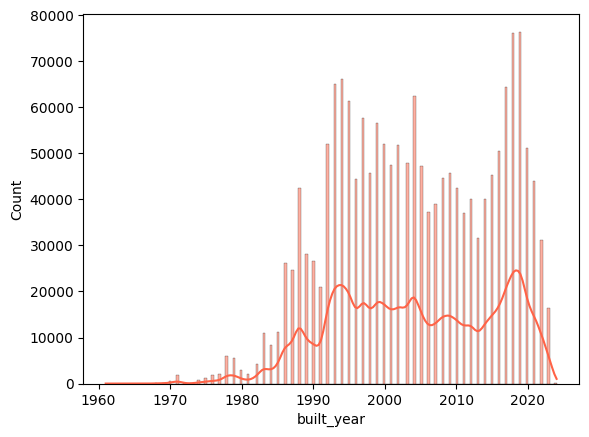

In [55]:
sns.histplot(data=train_data, x="built_year", color="tomato", kde=True)

<Axes: xlabel='latitude', ylabel='Count'>

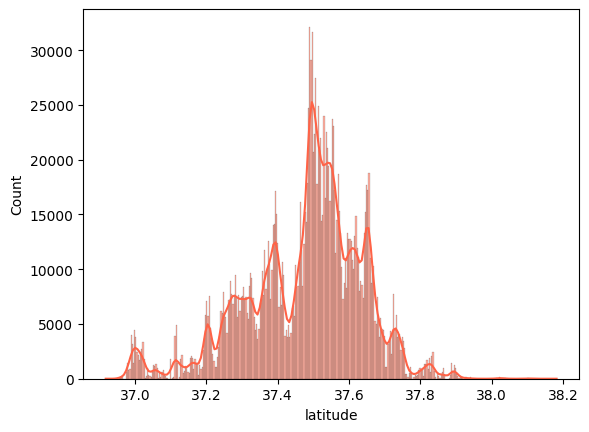

In [56]:
sns.histplot(data=train_data, x="latitude", color="tomato", kde=True)

<Axes: xlabel='longitude', ylabel='Count'>

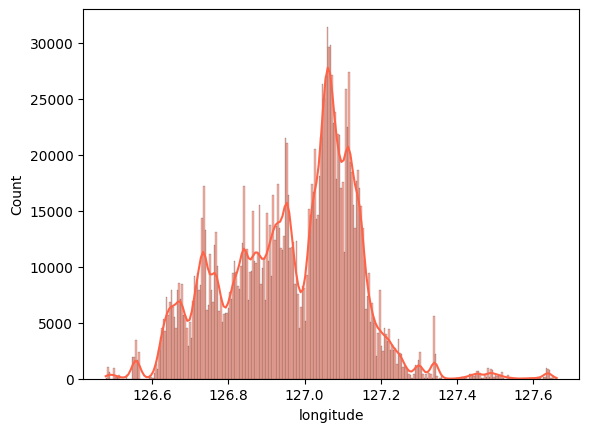

In [57]:
sns.histplot(data=train_data, x="longitude", color="tomato", kde=True)

<Axes: xlabel='age', ylabel='Count'>

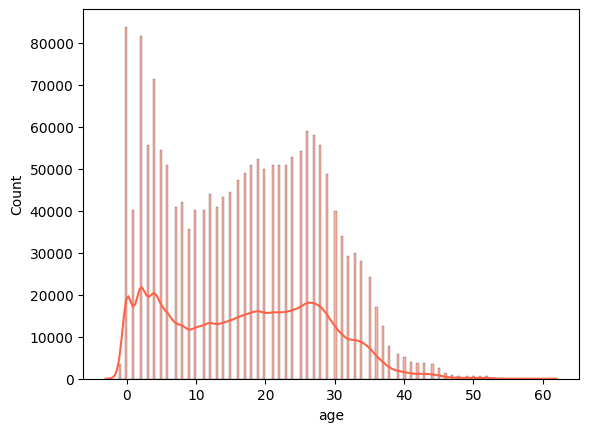

In [58]:
sns.histplot(data=train_data, x="age", color="tomato", kde=True)

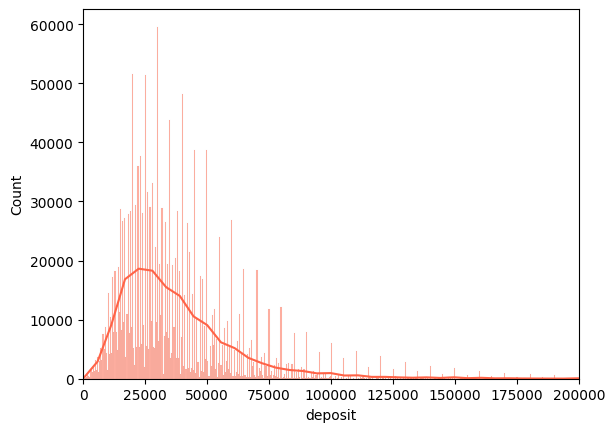

In [59]:
sns.histplot(data=train_data, x="deposit", color="tomato", kde=True)
plt.xlim(0, 200000)
plt.show()

<Axes: xlabel='school_distance', ylabel='Count'>

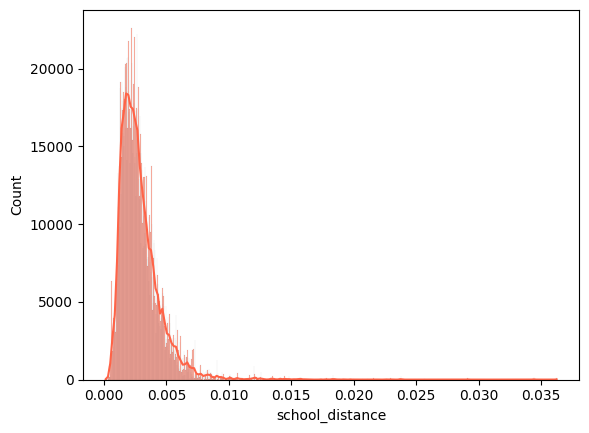

In [60]:
sns.histplot(data=train_data, x="school_distance", color="tomato", kde=True)

<Axes: xlabel='park_distance', ylabel='Count'>

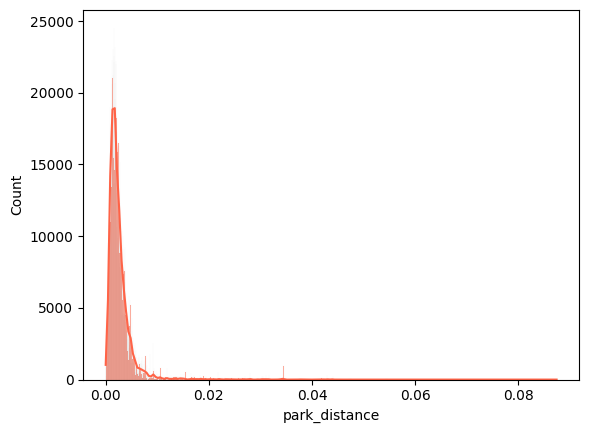

In [61]:
sns.histplot(data=train_data, x="park_distance", color="tomato", kde=True)

<Axes: xlabel='subway_distance', ylabel='Count'>

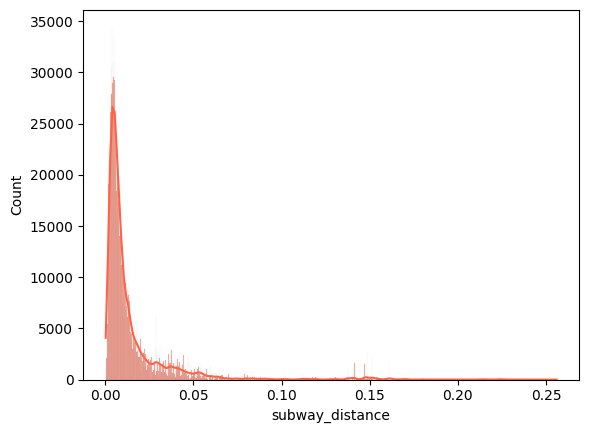

In [62]:
sns.histplot(data=train_data, x="subway_distance", color="tomato", kde=True)

<Axes: xlabel='interest_rate', ylabel='Count'>

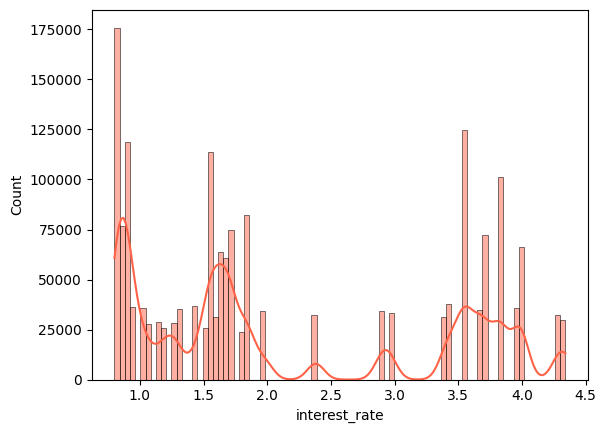

In [63]:
sns.histplot(data=train_data, x="interest_rate", color="tomato", kde=True)

### Boxplot

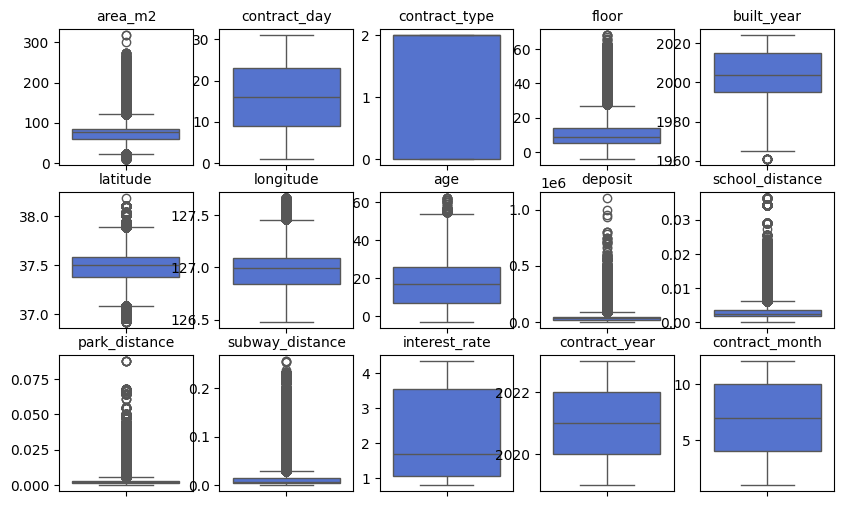

In [64]:
fig, axs = plt.subplots(3, 5, figsize= (10, 6))

for i, feature in enumerate(train_data):
    sns.boxplot(data=train_data, y=feature, color="royalblue", ax=axs[i//5, i%5])
    axs[i//5, i%5].set_title(feature, fontsize=10)
    axs[i//5, i%5].set_ylabel("")

plt.show()

In [65]:
# 이상치 탐지
def find_outliers_iqr(data: pd.Series) -> pd.Series:
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]

deposit_outliers = find_outliers_iqr(train_data["deposit"]).index
train_data.drop(deposit_outliers, axis=0, inplace=True)

# Linear Regression (vanilla)

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop("deposit", axis=1), train_data["deposit"], test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_valid)

mae_lr = mean_absolute_error(y_valid, y_pred)
print(mae_lr)

10635.474752324451


In [86]:
test_fillna = test_data.fillna(method="ffill")

In [87]:
# Vanila lr output
output = lr_model.predict(test_fillna)
submission_df["deposit"] = output
submission_df.to_csv("output.csv", index=False)

## Polynomial
- latitude나 longitude와 같은 변수는 1차보다는 2차항으로 만드는 것이 더 좋을 것이라고 생각해 적용해봄.

In [78]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso

# 세 모델에 대해 이차항 생성과 모델 생성을 하나의 파이프라인으로 연결
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_Ridge = make_pipeline(PolynomialFeatures(degree=2), Ridge(random_state=42))
poly_Lasso = make_pipeline(PolynomialFeatures(degree=2), Lasso(random_state=42))

# 모델 훈련
poly_model.fit(X_train, y_train)
poly_Ridge.fit(X_train, y_train)
poly_Lasso.fit(X_train, y_train)

# 예측
y_pred_poly = poly_model.predict(X_valid)
y_pred_poly_Ridge = poly_Ridge.predict(X_valid)
y_pred_poly_Lasso = poly_Lasso.predict(X_valid)

# 평가
mae_poly = mean_absolute_error(y_valid, y_pred_poly)
mae_poly_Ridge = mean_absolute_error(y_valid, y_pred_poly_Ridge)
mae_poly_Lasso = mean_absolute_error(y_valid, y_pred_poly_Lasso)

# MAE 출력
print("#### Polynomial MAE ####")
print(f"linear: {mae_poly}")
print(f"Ridge: {mae_poly_Ridge}")
print(f"Lasso: {mae_poly_Lasso}")

#### Polynomial MAE ####
linear: 8393.6831277846
Ridge: 8617.317548436822
Lasso: 9990.098215100099


In [88]:
# Polynomial lr output
output = poly_model.predict(test_fillna)
submission_df["deposit"] = output
submission_df.to_csv("output.csv", index=False)

원하는 변수만 2차항 생성

In [68]:
# poly = PolynomialFeatures(2, include_bias=False)
# train_poly = poly.fit_transform(train_data[['latitude', 'longitude']])

# # 변환된 다항식 항목을 데이터프레임으로 변환
# train_poly_df = pd.DataFrame(train_poly, columns=poly.get_feature_names_out(['latitude', 'longitude']))
# train_poly_df = pd.concat([train_poly_df, train_data], axis=1)
# X_train_poly, X_valid_poly, y_train_poly, y_valid_poly = train_test_split(train_poly_df.drop(["deposit"], axis=1), train_poly_df["deposit"], test_size=0.2, random_state=42)

# lr_model.fit(X_train_poly, y_train_poly)
# y_pred_poly2 = lr_model.predict(X_valid_poly)
# mae_poly2 = mean_absolute_error(y_valid_poly, y_pred_poly2)
# print(mae_poly2)

-> linear regression은 좀 별로인듯?

# CatBoost

In [70]:
from catboost import CatBoostRegressor
import optuna
import warnings
warnings.filterwarnings("ignore")

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
        "cat_features": ["contract_year",
                         "contract_month",
                         "contract_day",
                         "contract_type"],
        "task_type": "GPU",
        "devices": "0",
        "verbose": 0
    }

    cb_model = CatBoostRegressor(**params)
    cb_model.fit(X_train, y_train)
    y_pred_cb = cb_model.predict(X_valid)
    mae_cb = mean_absolute_error(y_valid, y_pred_cb)
    return mae_cb

# Optuna 스터디 생성
study = optuna.create_study(direction="minimize")  # MAE를 최소화하는 방향으로 설정

# 최적화 수행
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-10-02 13:31:56,964] A new study created in memory with name: no-name-83e5f033-8980-4b6a-b78b-45d7d5a72f3a
[I 2024-10-02 13:32:01,892] Trial 0 finished with value: 5064.635976927032 and parameters: {'iterations': 145, 'learning_rate': 0.20007559370273206, 'depth': 7, 'l2_leaf_reg': 5}. Best is trial 0 with value: 5064.635976927032.
[I 2024-10-02 13:32:32,581] Trial 1 finished with value: 5557.363298114152 and parameters: {'iterations': 908, 'learning_rate': 0.03035489827415373, 'depth': 5, 'l2_leaf_reg': 2}. Best is trial 0 with value: 5064.635976927032.
[I 2024-10-02 13:33:27,457] Trial 2 finished with value: 3741.653275979072 and parameters: {'iterations': 696, 'learning_rate': 0.26068913472147714, 'depth': 10, 'l2_leaf_reg': 7}. Best is trial 2 with value: 3741.653275979072.
[I 2024-10-02 13:33:39,046] Trial 3 finished with value: 5177.080301408505 and parameters: {'iterations': 224, 'learning_rate': 0.15065787259362284, 'depth': 6, 'l2_leaf_reg': 6}. Best is trial 2 with val

Best trial:
  Value: 3690.634522988499
  Params:
    iterations: 943
    learning_rate: 0.26757812282158033
    depth: 10
    l2_leaf_reg: 5


## CatBoost output

In [73]:
best_params = study.best_params
cat_model = CatBoostRegressor(**best_params)
cat_model.fit(train_data.drop("deposit", axis=1), train_data["deposit"])
output = cat_model.predict(test_data)
submission_df["deposit"] = output
submission_df.to_csv("output.csv", index=False)

0:	learn: 15033.4439437	total: 139ms	remaining: 2m 11s
1:	learn: 13188.7228110	total: 265ms	remaining: 2m 4s
2:	learn: 11995.0134640	total: 407ms	remaining: 2m 7s
3:	learn: 11182.2224866	total: 536ms	remaining: 2m 5s
4:	learn: 10556.7352942	total: 669ms	remaining: 2m 5s
5:	learn: 10128.6631811	total: 793ms	remaining: 2m 3s
6:	learn: 9788.0774827	total: 927ms	remaining: 2m 3s
7:	learn: 9519.3109646	total: 1.05s	remaining: 2m 2s
8:	learn: 9240.7257081	total: 1.18s	remaining: 2m 2s
9:	learn: 9052.1311718	total: 1.29s	remaining: 2m
10:	learn: 8912.7096493	total: 1.41s	remaining: 1m 59s
11:	learn: 8742.4266405	total: 1.53s	remaining: 1m 58s
12:	learn: 8638.3963709	total: 1.65s	remaining: 1m 58s
13:	learn: 8558.1435751	total: 1.77s	remaining: 1m 57s
14:	learn: 8492.0543833	total: 1.9s	remaining: 1m 57s
15:	learn: 8411.5913567	total: 2.02s	remaining: 1m 57s
16:	learn: 8329.8913258	total: 2.15s	remaining: 1m 56s
17:	learn: 8272.9942624	total: 2.26s	remaining: 1m 56s
18:	learn: 8220.4863686	tot